# Study of the network dataset

In this notebook, we will study how different models perform on the network dataset. Some of the models we will study are:
1. Non-supervised:
    - Isolation Forest (IF)
    - Local Outlier Factor (LOF)
2. Neural Networks:
    - DNN
    - LSTM
3. Supervised classifiers:
    - Decision Tree
    - Random Forest
    - XGBoost

First, let's import the necessary libraries.

In [77]:
from preprocess_data import get_HITL, clean_HITL, prepare_HTIL_network_dataset, remove_network_contextual_columns

from mlsecu.data_exploration_utils import (
    get_column_names,
    get_nb_of_dimensions,
    get_nb_of_rows,
    get_object_column_names,
    get_number_column_names,
)
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_preparation_utils import (
    get_one_hot_encoded_dataframe,
    remove_nan_through_mean_imputation,
)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    balanced_accuracy_score,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
from tensorflow.keras.activations import swish, sigmoid, softmax

BASE_PATH = "../../data/"
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Load and prepare the dataset

We have defined multiple preprocessing functions in the `preprocessing.py` file. We will use them to load and prepare the dataset.

In [2]:
hitl_dict = get_HITL("../../data/HardwareInTheLoop/", small=True)
df_network, _ = clean_HITL(hitl_dict) # Clean-up helper function

print("Network dataset shape: ", df_network.shape)

Network dataset shape:  (243065, 17)


In [3]:
df_network_prepared, df_network_labels = prepare_HTIL_network_dataset(df_network)
df_network_prepared.head()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst,mac_s_00:0c:29:47:8c:22,mac_s_00:80:f4:03:fb:12,mac_s_0a:fe:ec:47:74:fb,...,modbus_response_[985],modbus_response_[988],modbus_response_[98],modbus_response_[991],modbus_response_[993],modbus_response_[994],modbus_response_[995],modbus_response_[999],modbus_response_[99],modbus_response_[9]
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_network_labels.head()

,label_n,label,attack,new_labels
0,0,normal,1,3
1,0,normal,1,3
2,0,normal,1,3
3,0,normal,1,3
4,0,normal,1,3


# Models analysis

## 1. Non-supervised models

### a. Isolation Forest

As a first step, let's try default parameters for the Isolation Forest model.

In [27]:
df_network_labels["label_n"].value_counts()

label_n
0    176087
1     66978
Name: count, dtype: int64

In [5]:
clf = IsolationForest(random_state=42)
y_pred = clf.fit_predict(df_network_prepared)
if_outliers = df_network_prepared[y_pred == -1].index.values.tolist()
len(if_outliers)

12505

In [6]:
df_network_labels.iloc[if_outliers]["label_n"].value_counts()

label_n
1    7695
0    4810
Name: count, dtype: int64

Out of the 12505 outliers found, 7695 are real anomalies (61.5%). This is not a great result knowing there are 66k outliers, let's see if we can do better with a fixed contamination rate.

In [23]:
val_counts_labels = df_network_labels["label_n"].value_counts()
contamination_rate = val_counts_labels[1] / (val_counts_labels[0] + val_counts_labels[1])
contamination_rate

0.2755559212556312

In [24]:
clf = IsolationForest(n_estimators=100, n_jobs=-1, bootstrap=True, random_state=42, contamination=contamination_rate)
y_pred = clf.fit_predict(df_network_prepared)
if_outliers_cr = df_network_prepared[y_pred == -1].index.values.tolist()
len(if_outliers_cr)

65687

In [25]:
df_network_labels.iloc[if_outliers_cr]["label_n"].value_counts()

label_n
1    37940
0    27747
Name: count, dtype: int64

With a fixed contamination rate, the model gets a total of 65687 outliers, out of which 37940 are real anomalies (57.7%). This is a worse results than the default parameters, but more outliers are found.

### b. Local Outlier Factor

In [ ]:
clf = LocalOutlierFactor(n_neighbors=5)
y_pred = clf.fit_predict(df_network_prepared)
lof_outliers = df_network_prepared[y_pred == -1].index.values.tolist()
len(lof_outliers)

In [ ]:
df_network_labels.iloc[lof_outliers]["label_n"].value_counts()

## 2. Neural Networks

### a. DNN

We will use only some of the columns for the DNN model. We are removing contextual information such as the time and the source and destination IPs. To make it easier to manipulate, we will merge back the labels with the predictions.

#### Binary classification

In [34]:
df = df_network_prepared.copy()
df["label_n"] = df_network_labels["label_n"]
df = df[["sport", "dport", "flags", "size", "n_pkt_src", "n_pkt_dst", "label_n"]]
df.head()

,sport,dport,flags,size,n_pkt_src,n_pkt_dst,label_n
0,56666.0,502.0,11000.0,66,50.0,15.0,0
1,502.0,56666.0,11000.0,64,15.0,50.0,0
2,56668.0,502.0,11000.0,66,50.0,15.0,0
3,502.0,56668.0,11000.0,65,15.0,50.0,0
4,502.0,56666.0,11000.0,65,15.0,50.0,0


In [35]:
# convert bool columns to int
bool_cols = df.columns[df.dtypes == bool]
df[bool_cols] = df[bool_cols].astype(int)

# remove time column
if "Time" in df.columns:
    df.drop(columns=['Time'], inplace=True)

# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_n'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label_n'])

# Separate features and target
X_train = train_df.drop(columns=['label_n'])
y_train = train_df['label_n']
X_val = val_df.drop(columns=['label_n'])
y_val = val_df['label_n']
X_test = test_df.drop(columns=['label_n'])
y_test = test_df['label_n']

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((155561, 6), (38891, 6), (48613, 6))

In [36]:
X_train[0]

array([-1.07814864,  1.15211731,  0.11232352, -0.36686064, -0.91858689,
        0.23207069])

In [39]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train[0].shape[0],)),  # Input layer
    tf.keras.layers.Dense(1024, activation=swish),  # Hidden layer 1
    tf.keras.layers.Dense(256, activation=swish),   # Hidden layer 2
    tf.keras.layers.Dense(64, activation=swish),   # Hidden layer 3
    tf.keras.layers.Dense(1, activation=sigmoid)  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              7168      
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 286081 (1.09 MB)
Trainable params: 286081 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's define callbacks

In [40]:
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=6, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=256, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_on_plateau])

Epoch 1/10
608/608 [==============================] - 3s 4ms/step - loss: 0.3281 - accuracy: 0.8704 - val_loss: 0.3129 - val_accuracy: 0.8698 - lr: 0.0010
Epoch 2/10
608/608 [==============================] - 3s 5ms/step - loss: 0.3045 - accuracy: 0.8746 - val_loss: 0.3015 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 3/10
608/608 [==============================] - 3s 5ms/step - loss: 0.3019 - accuracy: 0.8754 - val_loss: 0.3001 - val_accuracy: 0.8771 - lr: 0.0010
Epoch 4/10
608/608 [==============================] - 3s 5ms/step - loss: 0.3020 - accuracy: 0.8755 - val_loss: 0.2980 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 5/10
608/608 [==============================] - 3s 5ms/step - loss: 0.3004 - accuracy: 0.8756 - val_loss: 0.2977 - val_accuracy: 0.8774 - lr: 0.0010
Epoch 6/10
608/608 [==============================] - 3s 5ms/step - loss: 0.2997 - accuracy: 0.8758 - val_loss: 0.3001 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 7/10
608/608 [==============================] - 3s 5ms/step - lo

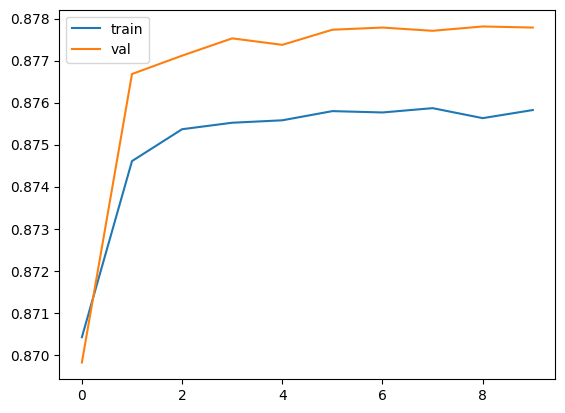

In [41]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

Evaluation on the test set:

In [42]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

1520/1520 [==============================] - 1s 754us/step - loss: 0.2990 - accuracy: 0.8763
Test accuracy: 87.63%


In [119]:
def plot_confusion_matrix(y_true, y_pred, title=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    if title:
        ax.set_title(title)
    plt.show()

In [ ]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, title="Confusion matrix for the test set")

#### Multiclass classification

Now, we want to create an alternative DNN which will give us more precision on the type of attack. We will use the same architecture as before, but we will change the output layer to have 5 neurons, one for each type of attack.

In [48]:
df.drop(columns=['label_n'], inplace=True)
df["new_labels"] = df_network_labels["new_labels"]
df["new_labels"].value_counts()

new_labels
3    176087
0     37665
1     16841
4     12469
2         3
Name: count, dtype: int64

Let's delete the class 2

In [59]:
df = df[df["new_labels"] != 2]
df["new_labels"].value_counts()

new_labels
3    176087
0     37665
1     16841
4     12469
Name: count, dtype: int64

In [60]:
# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['new_labels'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['new_labels'])

# Separate features and target
X_train = train_df.drop(columns=['new_labels'])
y_train = train_df['new_labels']
X_val = val_df.drop(columns=['new_labels'])
y_val = val_df['new_labels']
X_test = test_df.drop(columns=['new_labels'])
y_test = test_df['new_labels']

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((155559, 6), (38890, 6), (48613, 6))

In [69]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train[0].shape[0],)),  # Input layer
    tf.keras.layers.Dense(1024, activation=swish),  # Hidden layer 1
    tf.keras.layers.Dense(256, activation=swish),   # Hidden layer 2
    tf.keras.layers.Dense(64, activation=swish),   # Hidden layer 3
    tf.keras.layers.Dense(5, activation=softmax)  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1024)              7168      
                                                                 
 dense_17 (Dense)            (None, 256)               262400    
                                                                 
 dense_18 (Dense)            (None, 64)                16448     
                                                                 
 dense_19 (Dense)            (None, 5)                 325       
                                                                 
Total params: 286341 (1.09 MB)
Trainable params: 286341 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=256, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_on_plateau])

Epoch 1/10


608/608 [==============================] - 3s 5ms/step - loss: 0.4457 - accuracy: 0.8708 - val_loss: 0.3966 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 2/10
608/608 [==============================] - 3s 4ms/step - loss: 0.3956 - accuracy: 0.8757 - val_loss: 0.3866 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 3/10
608/608 [==============================] - 3s 5ms/step - loss: 0.3920 - accuracy: 0.8760 - val_loss: 0.3850 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 4/10
608/608 [==============================] - 3s 5ms/step - loss: 0.3911 - accuracy: 0.8761 - val_loss: 0.3876 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 5/10
608/608 [==============================] - 3s 5ms/step - loss: 0.3899 - accuracy: 0.8762 - val_loss: 0.3845 - val_accuracy: 0.8759 - lr: 0.0010
Epoch 6/10
608/608 [==============================] - 3s 5ms/step - loss: 0.3890 - accuracy: 0.8763 - val_loss: 0.3885 - val_accuracy: 0.8764 - lr: 0.0010
Epoch 7/10
608/608 [==============================] - 3s 5ms/step - loss: 0.3876 

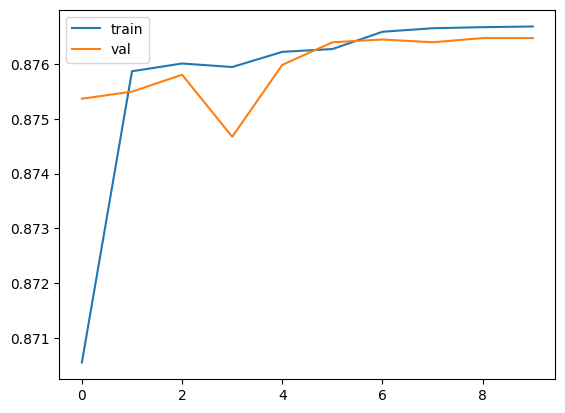

In [63]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

Evaluate on the test set:

In [64]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

1520/1520 [==============================] - 1s 650us/step - loss: 0.3858 - accuracy: 0.8766
Test accuracy: 87.66%


1520/1520 [==============================] - 1s 564us/step


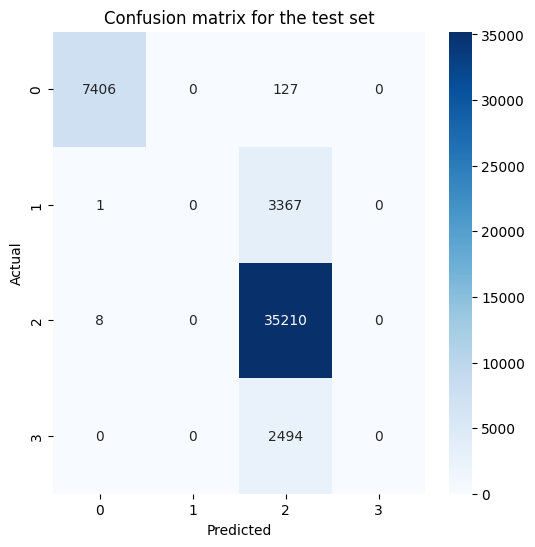

In [65]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred = y_pred = np.argmax(y_pred, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, title="Confusion matrix for the test set")

A very strange behavior is observed: the model is not able to predict any class other than 0 (one type of attack) and 2 (normal traffic). This is probably due to the fact that the dataset is very unbalanced, and the model is not able to learn the other classes.

In [66]:
# get recall, precision, f1-score, and accuracy
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("F1-score: ", f1_score(y_test, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Recall:  0.49572842259311645
Precision:  0.46335984565041666
F1-score:  0.47810913750022965
Accuracy:  0.8766379363544731


/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/MLSECU/ML-SECU2024/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As expected, only the accuracy is good, but the precision and recall are very low.

### b. LSTM

#### Binary classification

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df_network_prepared, df_network_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Let's create a PyTorch dataset

In [76]:
class HITLDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = HITLDataset(X_train_scaled, y_train["label_n"].to_numpy())
test_dataset = HITLDataset(X_test_scaled, y_test["label_n"].to_numpy())
val_dataset = HITLDataset(X_val_scaled, y_val["label_n"].to_numpy())

# Create pytorch dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [78]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out
    
input_dim = X_train_scaled.shape[1]
output_dim = len(y_train["label_n"].unique())
hidden_dim = 32
model = LSTM(input_dim, hidden_dim, output_dim)
model

LSTM(
  (lstm): LSTM(1986, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [79]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [80]:
from tqdm import tqdm

def train(model, train_loader, val_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    for X, y in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (y_pred.argmax(1) == y).sum().item()

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(val_loader, total=len(val_loader)):
            y_pred = model(X)
            loss = criterion(y_pred, y)
            val_loss += loss.item()
            val_acc += (y_pred.argmax(1) == y).sum().item()
    return train_loss / len(train_loader), train_acc / len(train_loader.dataset), val_loss / len(val_loader), val_acc / len(val_loader.dataset)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    test_acc = 0
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for X, y in test_loader:
            y_pred = model(X)
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            test_acc += (y_pred.argmax(1) == y).sum().item()
            y_pred_list.append(y_pred.argmax(1).cpu().numpy())
            y_true_list.append(y.cpu().numpy())
    return test_loss / len(test_loader), test_acc / len(test_loader.dataset)

100%|██████████| 1216/1216 [00:01<00:00, 759.53it/s]


Train loss: 0.3745, Train acc: 0.8627, Val loss: 0.3562, Val acc: 0.8679


100%|██████████| 1216/1216 [00:01<00:00, 803.39it/s]


Train loss: 0.3476, Train acc: 0.8727, Val loss: 0.3358, Val acc: 0.8769


100%|██████████| 1216/1216 [00:01<00:00, 846.51it/s]


Train loss: 0.3282, Train acc: 0.8757, Val loss: 0.3227, Val acc: 0.8765


100%|██████████| 1216/1216 [00:01<00:00, 800.51it/s]


Train loss: 0.3145, Train acc: 0.8752, Val loss: 0.3128, Val acc: 0.8770


100%|██████████| 1216/1216 [00:01<00:00, 791.90it/s]


Train loss: 0.3058, Train acc: 0.8755, Val loss: 0.3043, Val acc: 0.8782


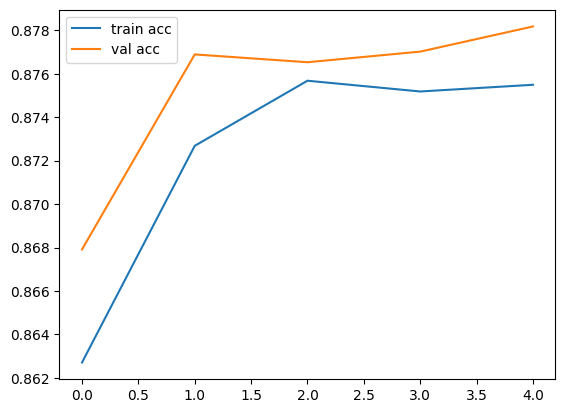

In [81]:
EPOCHS = 5
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for _ in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

# Plot train loss and accuracy
plt.plot(train_acc_list, label="train acc")
plt.plot(val_acc_list, label="val acc")
plt.legend()
plt.show()

In [82]:
test_loss, test_acc = test(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

Test loss: 0.3030, Test acc: 0.8781


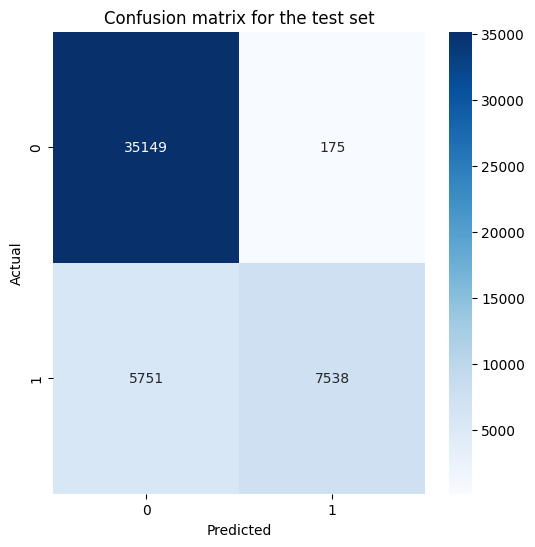

In [83]:
# Predict on test set
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X, y in test_loader:
        y_pred = model(X)
        y_pred_list.append(y_pred.argmax(1).cpu().numpy())
        y_true_list.append(y.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, title="Confusion matrix for the test set")

#### Multiclass classification

In [86]:
train_dataset = HITLDataset(X_train_scaled, y_train["new_labels"].to_numpy())
test_dataset = HITLDataset(X_test_scaled, y_test["new_labels"].to_numpy())
val_dataset = HITLDataset(X_val_scaled, y_val["new_labels"].to_numpy())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [87]:
input_dim = X_train_scaled.shape[1]
output_dim = len(y_train["new_labels"].unique())
hidden_dim = 32
model = LSTM(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 1216/1216 [00:01<00:00, 839.76it/s]


Train loss: 0.5067, Train acc: 0.8618, Val loss: 0.4680, Val acc: 0.8681


100%|██████████| 1216/1216 [00:01<00:00, 856.18it/s]


Train loss: 0.4541, Train acc: 0.8708, Val loss: 0.4399, Val acc: 0.8760


100%|██████████| 1216/1216 [00:01<00:00, 827.45it/s]


Train loss: 0.4359, Train acc: 0.8747, Val loss: 0.4287, Val acc: 0.8769


100%|██████████| 1216/1216 [00:01<00:00, 841.51it/s]


Train loss: 0.4228, Train acc: 0.8758, Val loss: 0.4195, Val acc: 0.8777


100%|██████████| 1216/1216 [00:01<00:00, 850.74it/s]

Train loss: 0.4102, Train acc: 0.8770, Val loss: 0.4117, Val acc: 0.8782


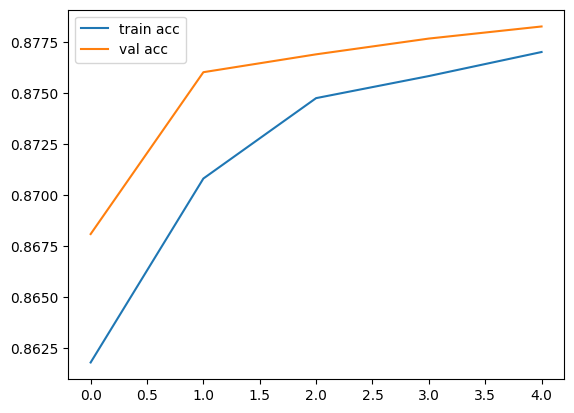

In [88]:
EPOCHS = 5
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for _ in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

# Plot train loss and accuracy
plt.plot(train_acc_list, label="train acc")
plt.plot(val_acc_list, label="val acc")
plt.legend()
plt.show()

In [89]:
test_loss, test_acc = test(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

Test loss: 0.4089, Test acc: 0.8789


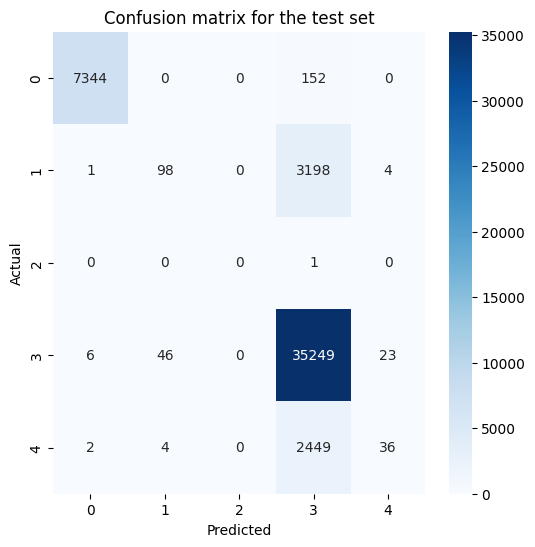

In [90]:
# Predict on test set
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X, y in test_loader:
        y_pred = model(X)
        y_pred_list.append(y_pred.argmax(1).cpu().numpy())
        y_true_list.append(y.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, title="Confusion matrix for the test set")

## 3. Supervised classifiers

### a. Decision Tree

#### Multiclass classification

We will not use the Decision Tree for the binary classification, as we want to focus on the features importance.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df_network_prepared, df_network_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194452, 1986), (48613, 1986), (194452, 2), (48613, 2))

Define the model with empirical parameters

In [92]:
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state
}

clf = DecisionTreeClassifier(**params)

In [93]:
pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

In [94]:
preds = pipeline.predict(X_test)

In [95]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.9329397486269105
Recall:  0.5697351629559801
F1:  0.6212123392376323
MCC:  0.8441165543717744
Balanced accuracy:  0.5697351629559801


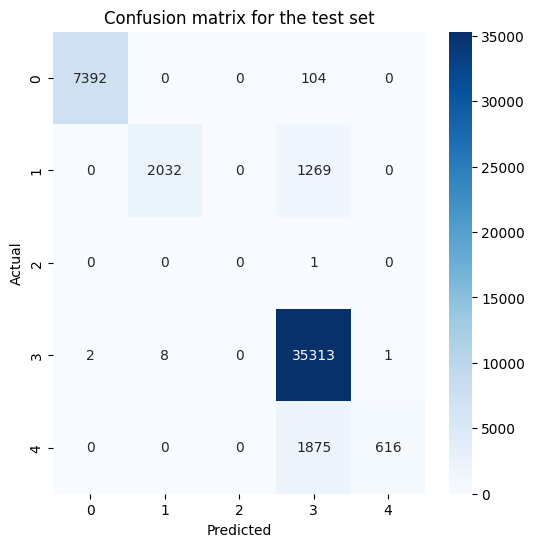

In [96]:
plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

Let's see which feature is the most important

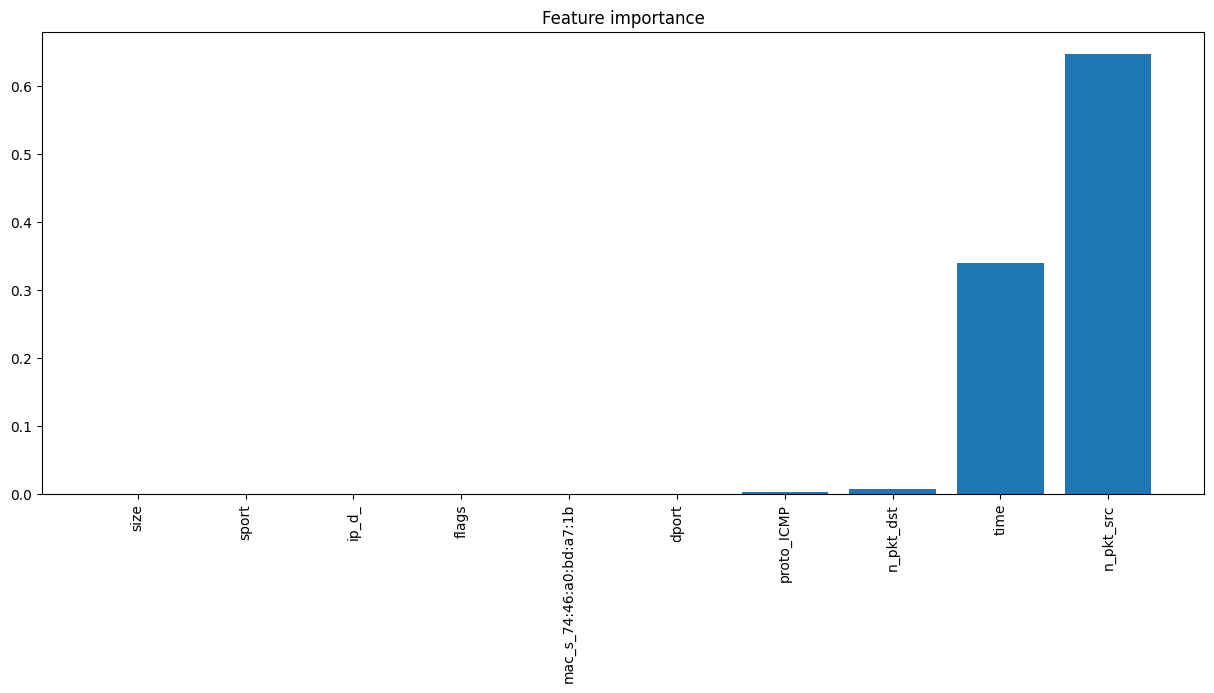

In [99]:
def plot_feature_importance(clf):
    importance = clf.feature_importances_
    # keep 10 most important features
    idx = np.argsort(importance)[-10:]
    importance = importance[idx]

    # plot feature importance
    plt.figure(figsize=(15, 6))
    plt.title("Feature importance")
    plt.bar([x for x in range(len(importance))], importance)
    plt.xticks([x for x in range(len(importance))], X_train.columns[idx], rotation='vertical')
    plt.show()

plot_feature_importance(clf)

#### Without contextual information

In [111]:
df_network_no_context = remove_network_contextual_columns(df_network)
df_network_no_context

,sport,dport,proto,flags,size,modbus_fn,n_pkt_src,n_pkt_dst,label_n,label,attack
0,56666.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,1
1,502.0,56666.0,Modbus,11000.0,64,Read Coils Response,15.0,50.0,0,normal,1
2,56668.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,1
3,502.0,56668.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,0,normal,1
4,502.0,56666.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,0,normal,1
...,...,...,...,...,...,...,...,...,...,...,...
243060,61516.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,0
243061,61516.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,0
243062,61517.0,502.0,Modbus,11000.0,66,Read Holding Registers,51.0,14.0,0,normal,0
243063,61515.0,502.0,Modbus,11000.0,66,Read Holding Registers,47.0,14.0,0,normal,0


In [112]:
df_network_prepared, df_network_labels = prepare_HTIL_network_dataset(df_network_no_context)
df_network_prepared.head()

,sport,dport,flags,size,n_pkt_src,n_pkt_dst,proto_ARP,proto_ICMP,proto_IP,proto_Modbus,proto_TCP,modbus_fn_,modbus_fn_Read Coils Request,modbus_fn_Read Coils Response,modbus_fn_Read Holding Registers,modbus_fn_Read Holding Registers Response
0,56666.0,502.0,11000.0,66,50.0,15.0,0,0,0,1,0,0,0,0,1,0
1,502.0,56666.0,11000.0,64,15.0,50.0,0,0,0,1,0,0,0,1,0,0
2,56668.0,502.0,11000.0,66,50.0,15.0,0,0,0,1,0,0,0,0,1,0
3,502.0,56668.0,11000.0,65,15.0,50.0,0,0,0,1,0,0,0,0,0,1
4,502.0,56666.0,11000.0,65,15.0,50.0,0,0,0,1,0,0,0,0,0,1


In [113]:
X_train, X_test, y_train, y_test = train_test_split(df_network_prepared, df_network_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194452, 16), (48613, 16), (194452, 2), (48613, 2))

In [114]:
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state
}

clf = DecisionTreeClassifier(**params)

In [115]:
pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

In [116]:
preds = pipeline.predict(X_test)

In [117]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.8776047559294838
Recall:  0.39588704410421466
F1:  0.38245737832039567
MCC:  0.7060071605653443
Balanced accuracy:  0.39588704410421466


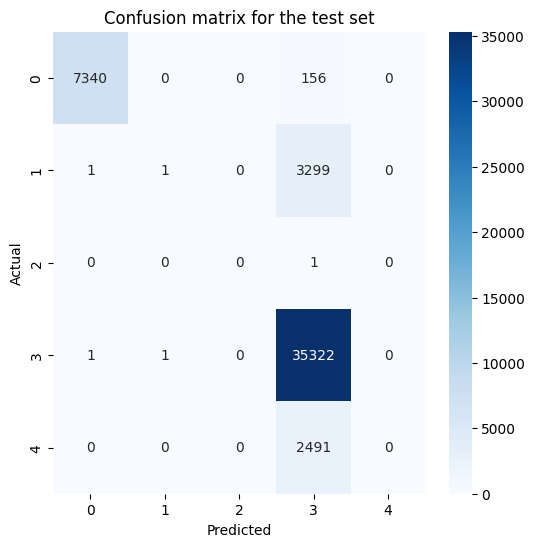

In [120]:
plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

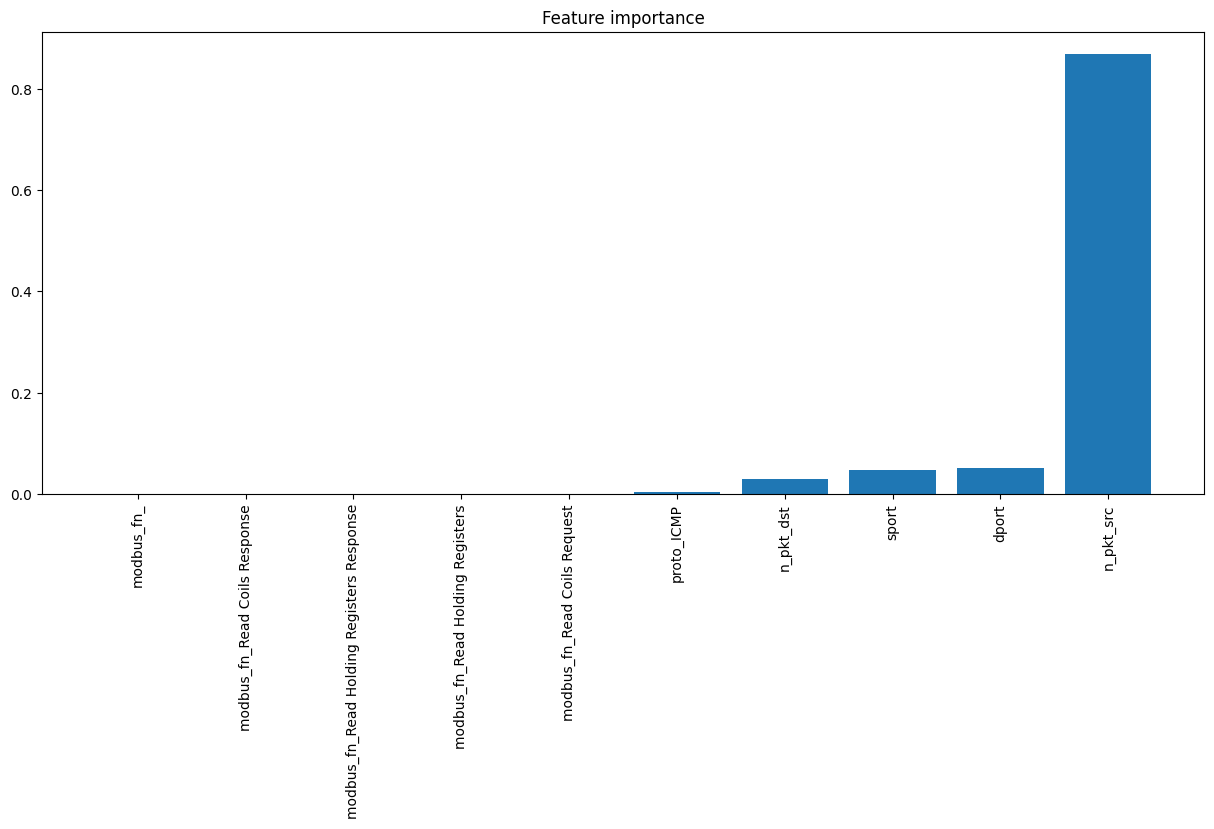

In [121]:
plot_feature_importance(clf)

### b. Random Forest

### c. XGBoost